In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Kinetic Ising Model simulation
Ising model with $N$ spins $\{-1,1\}$, cuplings matrix $J_{ij}$ and external field $h_i$. 

At each time step $\delta t$ each spin $s_i$ flips with a probability 
$$p_{flip} = \gamma \delta t \frac 1 2 [1-s_i(t)\tanh H_i(t)] \quad with \quad
H_i = h_i + \sum_{j \ne i} J_{ij}s_j(t)$$

In [55]:
class kinetic_ising:
    def __init__(self, N, J, h, gamma = 1):
        np.fill_diagonal(J,0)
        self.N = N
        self.J = np.copy(J)
        self.h = np.copy(h)
        self.S = np.ones(N)
        self.H_i = np.dot(self.J,self.S)+self.h
        self.gamma = gamma
        self.history = np.copy(self.S)
        
    def comp_H(self):
        #the last term is due to i!=j
        self.H_i = np.dot(self.J,self.S)+self.h
    
    def store(self):
        self.history = np.vstack((self.history,self.S))
    
    def update(self,dt):
        p = np.random.rand(N)
        p_up = dt*self.gamma*0.5*(1-self.S*np.tanh(self.H_i))
        self.S[p < p_up] *= -1
        self.store()
        self.comp_H()
        
    def reset(self):
        self.S = np.ones(N)
        self.history = np.copy(self.S)
    
    #if we put this func outside we can also use njit, we can also use the outer product instead of the for cycle  
    def C(self,dt):
        # NB : in our case history[i,j] i is the time and j is the spin
        C = np.zeros((N,N))
        # since C is simmetric we can optimize it ... 
        for i in tqdm(range(N),desc='Computing C'):
            for j in range(N):
                C[i,j] = np.mean(self.history[:,i]*self.history[:,j])
        
        C_dot = np.zeros((N,N))
        for i in tqdm(range(N),desc='Computing C_dot'):
            for j in range(N):
                C_dot[i,j] = np.mean(self.history[1:,i]*self.history[:-1,j])
        
        C_dot -= C
        C_dot /= dt
        
        return C,C_dot
    
        
        

In [149]:
np.random.seed(123)
#number of spins
N = 5

#interactions matrix
mu = 0
sigma = 1
J = np.random.normal(mu,sigma,(N,N))

#external field
mu = -0.2
sigma = 0.1
h = np.random.normal(mu,sigma,N)

gamma = 10
ising = kinetic_ising(N,J,h,gamma)

In [150]:
ising.reset()
np.random.seed(123)

time = 1
steps = 100
dt = time / steps
for i in range(steps):
    ising.update((dt))

In [151]:
C,C_dot = ising.C(dt)

Computing C_dot: 100%|██████████| 5/5 [00:00<00:00, 11026.04it/s]


Text(0.5, 1.0, '$J$')

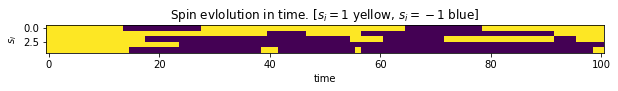

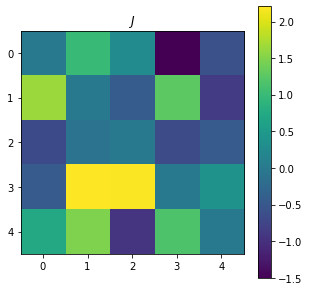

In [82]:
plt.figure(figsize=(10,3))
indcs = [i*10 for i in range(100)]
plt.imshow(ising.history.T)#[:,indcs])
plt.xlabel('time')
plt.ylabel(r'$s_i$')
plt.title(r'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

plt.figure(figsize=(5,5))
plt.imshow(J)
plt.colorbar()
plt.title(r'$J$')

## Inference

### Equations

$$
\dot C_{ij} = \delta t ^{-1} \cdot [\langle s_i(t+\delta t)\cdot s_j(t) \rangle_{t} - C_{i,j}] \\
C_{ij} = \langle s_i(t)\cdot s_j(t) \rangle_{t} \\
L = \frac 1 {N_t} \sum_t\sum_i \Big[ h_i\cdot s_i(t) + \big[\sum_{j\ne i} J_{ij}\cdot (\gamma^{-1}\dot{C_{ij}} + C_{ij})\big] - \log \cosh H_i(t)\Big]
$$

<span style="color:blue">C'e' qualcosa di sbagliato in L, la cosa che mi turba maggiormente e' che i parametri "veri" utilizzati per generare i dati non massimizzano la funzione, ma manco vagamente. Un secondo problema e' che la L sembra essere non limitata :( .</span>

In [147]:
from scipy.optimize import minimize

def logcosh(x):
    #the funcion is even, the trick is to avoid e^x
    x = np.abs(x)
    return np.log(1/2) + x + np.log(1 + np.exp(-2*x))

def L(p,s,C,C_dot,gamma):
    steps = len(s)
    # p are the params, s is the spins history
    N = len(s[0])
    J = p[:N*N].reshape((N,N))     # NxN matrix
    h = p[N*N:]                    # N vector

    
    C_i = C_dot/gamma + C
    C_i = np.sum(C_i*J,axis = 1) - np.diagonal(C_i*J)
    
    L = 0
    for S in s: #for each time
        H_i = np.dot(J,S) + h - np.diagonal(J)*S
        L += np.sum(-logcosh(H_i) + S*h + C_i)
    L /= -steps
    return L

#versione ottimizzata della funzione (e' super piu veloce); sfrutta numpy e le matrici
def L_mat(p,s,C,C_dot,gamma):
    N_t = len(s)
    # p are the params, s is the spins history
    N = len(s[0])
    J_0 = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J_0,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                      # N vector

    #first term
    a_i = C_dot/gamma + C
    a_i = np.sum(a_i*J_0,axis = 1)   #sum over j    
    A = np.sum(a_i)
    
    #second term
    H = np.tile(h,(N_t,1))
    B = H + np.dot(s,J_0.T)
    B = -np.sum(logcosh(B))/N_t
    
    #third term
    C = np.dot(s,h)
    C = np.sum(C)/N_t
    print(A,B,C)
    L = A + B + C
    return -L

In [145]:
#little check
s_test = np.array([[1,1],[1,1],[1,-1]])
h_test = np.array([0.5,-0.5])
J_test = np.array([[0,1],[2,0]])
C_dot_test = np.array([[-2,0.5],[0.5,-2]])
C_test = np.array([[1,0.5],[0.5,1]])
p_test = np.concatenate((J_test.flatten(),h_test))
L_mat(p_test,s_test,C_test,C_dot_test,1)

3.0 -1.46577178734242 0.3333333333333333


-1.8675615459909132

Ho confrontato i risultati con dei calcoli fatti a mano, il problema e' che il risultato sembra coincidere.

# Da qua in poi c'e' merda (anche prima mi sa)
### TEST on L

In [39]:
#bounds = [(-3,3) for i in range(N*N+N)]

p_real = np.concatenate((J.flatten(),h))
p_0 = np.random.normal(0,0.1,N*N+N)
p_0 = np.ones(N*N+N)
p_inf = minimize(L_mat,p_0,args=(ising.history,C,C_dot,gamma)).x

In [40]:
-L_mat(p_inf,ising.history,C,C_dot,gamma)

133605137.54078318

In [20]:
L(p_real,ising.history,C,C_dot,gamma)

-3.207987778996466

In [11]:
for i,j in zip(p_inf,p_real):
    print(abs(i-j))

1.0856306033005612
17286093.02346152
19286720.984996807
50849524.68316073
49777292.09426136
3982857.393907291
2.426679243393074
15216189.907910483
16137407.386289129
104602302.67930539
12836554.15588847
23568893.386914764
1.4913896261242878
23753553.862393368
39616224.07566347
24008730.265092008
13471008.072423682
23682671.7058759
1.004053897878877
5118510.797624693
332085.69065057463
41141338.561262086
15413041.776112197
20597067.56318615
1.2538806677490124
16351742.564081658
6188485.947925074
30384749.188754495
5180368.018027649
21807821.028785184


In [27]:
a = np.array([[1,2],[3,4]])
b = np.array([2,2])
print(np.dot(a,b))
np.dot(a,b) - np.diagonal(a)*b

[ 6 14]


array([4, 6])

### Gradinent

In [84]:
def L_grad(p,s,C,C_dot,gamma):
    N_t = len(s)
    # p are the params, s is the spins history
    N = len(s[0])
    J_0 = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J_0,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                      # N vector

    dh = np.tile(h,(N_t,1))
    dh = dh + np.dot(s,J_0.T)
    dh = s - np.tanh(dh)
    dh = np.mean(dh,axis=0)
    # lambda
    
    dJ = C_dot/gamma + C
    O = np.zeros((N,N))
    for S in s:
        H_i = np.tanh(h + np.dot(J,S))
        O += np.outer(H_i,S)
    O /= N_t
    dJ -= O
    #lambda
    
    return np.concatenate((dJ.flatten(),dh))

In [85]:
L_grad(p_real,ising.history,C,C_dot,gamma)

array([-0.06305778,  0.14349591,  0.16746346,  0.03670802,  0.06323095,
       -0.57353393, -0.07757367, -0.19112606,  0.50312672, -0.51853657,
        0.30109027,  0.43116437, -0.03874245,  0.28182747,  0.6377173 ,
        0.05047622, -0.14073944,  0.12137457,  0.19399546,  0.49427932,
        0.09256719, -0.35135785,  0.47669901,  0.07581373, -0.41845342,
       -0.01234728, -0.20557775, -0.04164123, -0.25770774, -0.62264586])

## Optimization

In [106]:
x_0 = np.random.normal(0,2,N*N+N)
l_r = 10
L_v = -L_mat(x_0,ising.history,C,C_dot,gamma)
L_list =[]
for i in tqdm(range(10000)):
    x_0 += l_r*L_grad(x_0,ising.history,C,C_dot,gamma)
    L_list.append(-L_mat(x_0,ising.history,C,C_dot,gamma))

100%|██████████| 10000/10000 [00:11<00:00, 875.21it/s]


In [121]:
L_grad(x_0-223,ising.history,C,C_dot,gamma)

array([ 0.64554455,  0.25346535, -0.03168317, -1.22772277, -1.16039604,
       -0.36039604,  0.03168317, -0.23366337,  0.96237624, -0.13069307,
       -0.44752475, -0.03168317, -0.17029703,  0.51881188,  0.84356436,
        0.34257426,  0.40594059,  0.56435644,  0.27524752,  0.48910891,
        0.66930693,  0.65346535,  0.22970297, -0.05148515, -0.78415842,
       -0.15841584,  0.47524752,  0.37623762, -0.03960396, -0.47524752])

1.98019801980198 -6.622204492490444 -0.5247524752475248
1.981049504950495 -6.626624409585901 -0.5247524752475248
1.9819009900990097 -6.63107109119876 -0.5247524752475248
1.9827524752475247 -6.635544475702334 -0.5247524752475248


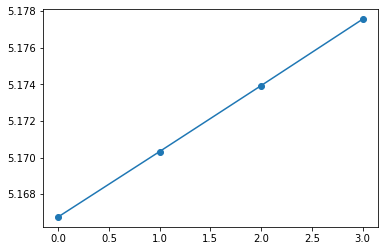

In [162]:
x = np.ones(N*N + N)
y = []
for i in range(4):
    y.append(L_mat(x,ising.history,C,C_dot,gamma))
    x[1]+= 0.01
plt.plot(y,'-o')